# Introduction to Convolutional Neural Networks
### Machine Learning 410
### Steve Elston

## 1.0 Introduction to convolutional neural networks

This lesson introduces you to a powerful neural network architecture, known as **convolutional neural networks**. Convolutional neural networks operate by learning a set of **filters**  or **kernels**. Using a process, known as **convolution**, these filters extract a **feature map** from the raw data. The feature map is a **lower dimensional** map of the features which is used for suppervised machine learning. In other words, convolutional neural networks and a powerful and flexible **dimensionality reduction** method. 

Convolutional neural networks are used to build feature maps from any type of data with coherency in one or more dimensions. This includes time series data, and text data as one dimensional cases, and image data as a two dimensional case. 

In this lesson you will learn:
1. The basics of convolutional neural network architecture.
2. How convolutional neural networks learn the filters to create the feature map. 
3. Feature extraction for creating the feature map. 
4. Visualization of the feature map and the filters.
5. Commonly used convolutional opertor design. 
6. How to use the feature map in suppervised learning. 

In [1]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt

%matplotlib inline

### 1.1 Convolution in 1 dimension

To get started, let's work with the simplest case of one dimensional convolution. Convolution is a process of applying a filter of a certain span over one of more dimensions of the data. 

To conceptually understand 1-d convolution examine Figure 1.1 below.. At each time step a value for output series is computed by applying the convolution operator to the input series. The convolution operator is a set of weights $\{ W_1, W_2, W_3 \}$ which are mutilied by the input values. The weighted inputs are then summed to compute the value of the output series. The operator is then moved along the input series (by the stride of 1 in this case). The procecss proceeds until the end of the series is reached. 

Notice that the output series is shorter than the input series by $\frac{Span + 1}{2}$. This reduction in the length of the output is inherent in all convolution operations. 

![](img/ParameterSharing.JPG)
<center>**Figure 1.1. 1-d convolution with operator span of 3**</center> 

Mathematically, we write the convolution operation:

$$s(t) = (x * k)(t) = \sum_{\tau = -\infty}^{\infty} x(\tau) k(t - \tau)$$
where,   
$s(t)$ is the output of the convolution operation at time $t$,  
$x$ is the series of values,  
$k$ is the convolution kernel,  
$*$ is the convolution operator,  
$\tau$ is the time difference of the convolution operator.  


Summing over the range $\{-\infty, \infty \}$ seems to be a problem. However, in practice the convolutional kernal has a finite span, $s$. For an operator with an odd numbered span, we can then rewrite the above equation as:

$$s(t) = (x * k)(t) = \sum_{\tau = {t - \frac{1}{2}s}}^{t + \frac{1}{2}s} x(\tau) k(t - \tau)$$

In other words, we only need to take the sum over the span of the convolution operator. Notice that this operator is non-causal, since values from ahead of the time step being operated on are used to compute the output. 

To make this all a bit more concrete, let's try a code example. We will construct a short filter and apply it over a time series. The code in the cell below implements a simple 1-d convolution operation given a set of kernel weights. The core of this operation is a dot product between the subset of values of the series and the kernel weights. The kernel in this case is a type of moving average operator. 

In [25]:
nr.seed(12233)
kernel = np.array([0.25, 0.5, 0.25])

def conv_1d(series, kernel):
    '''Performs simple 1d convolution over the series values
    given the kernel weights. This function only works for 
    kernels with odd span'''
    out =[]
    span = kernel.shape[0]
    half_span = int((span - 1)/2)
    len = series.shape[0]
    for i in range(0, len - span):   
        out.append(np.dot(series[i:i+span], kernel))
    return np.array(out)        
        
series = np.concatenate((nr.normal(size = 40), nr.normal(size = 40) + 2.0))  
result = conv_1d(series, kernel)

To examine the results, check 

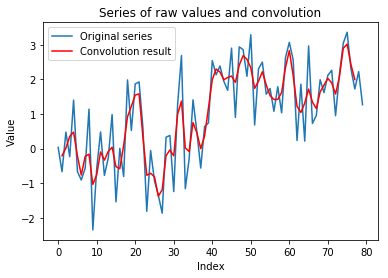

In [27]:
def plot_conv(series, conv, span):
    x = list(range(series.shape[0]))
    offset = int((span-1)/2)
    end = series.shape[0] - offset -1
    plt.plot(x, series, label = 'Original series')
    plt.plot(x[offset:end], conv, color = 'red', label = 'Convolution result')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Series of raw values and convolution')
    
plot_conv(series, result, 3)    

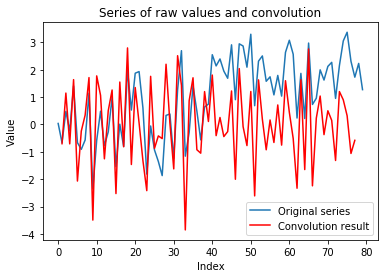

In [32]:
kernel = np.array([-1.0,1.0,0.0])
result = conv_1d(series, kernel)
plot_conv(series, result, 3)  

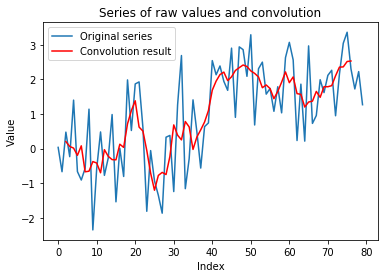

In [29]:
kernel = np.array([1.0/5.0,1.0/5.0,1.0/5.0,1.0/5.0,1.0/5.0])
result = conv_1d(series, kernel)
plot_conv(series, result, 5)  

### 1.2 Applying 2-d convolution

Next, let's look at how we can apply convolution operations in two dimensions. The theory is the same as the 1d case.  

Figure 1.2 illustrates a simple example of applying a convolution operator to a 2-d input array. The 2-d input array can be a gray-scale image, for example. 

A 3X3 operator is illustrated in Figure 1.2. This operator is applied to a small image of dimension of 4X4 pixels. Within the 4X4 image the operator is only applied four times, where the complete opertor lies on the image. Convolution where the operator is completely contained within the input sample is sometimes called call **valid convolution**. In this case the 4X4 pixel input results in a 2X2 pixel output. Similar to the 1-d case, for a convolution operator with span $s$ in both dimensions the output array will be reduced in each dimension by $\frac{s + 1}{2}$

![](img/2D-Conv.JPG)
<center>**Figure 1.2. Simple 2-d convolution operation**</center>

For a convolution with the identical span $s$ in both dimensions we can write the convolution operations as: 

$$S(i,j) = (I * K)(i,j) = \sum_{m = {i - \frac{1}{2}s}}^{i + \frac{1}{2}s} \sum_{n = j - \frac{1}{2}s}^{j + \frac{1}{2}s} I(i, j) K(i-m, j-n)$$

Notice that $S$, $I$ and $K$ are all tensors. Given this fact, the above formula is easily extended to higher dimensional problems. 

The convoluational kernel $K$ and the image $I$ are comutitive so there is an alternative representation by applying an operation known as **kernel flipping**. Flipped kernel convolution can be represented as follows:

$$s(i,j) = (I * K)(i,j) = \sum_{m = {i - \frac{1}{2}s}}^{i + \frac{1}{2}s} \sum_{n = j - \frac{1}{2}s}^{j + \frac{1}{2}s} I(i-m, j-n) K(i, j)$$


### 1.3 Convolution in higher dimensions

In deep convolutional neural networks the input typically have several **input channels** with the convolution operation resulting in multiple **output channels**. 

So far, we have only looked at single channel convolution. Here are some examples of input tensors with different numbers of input channels:
- A gray-scale image has a single input channel of pixels. 
- A color image typically has 3 input channels, {Red, Green, Blue}.
- A color movie has a large number of input channels. For $n$ images in the video there are $3 * n$ images counting the Red, Green, Blue channels for each image.  

The purpose of the a convolutional neural network is to create a feature map. To create the most general feature map convoluation operators need not be restricted to a single input channel. 

Further, the feature map can can many channels, resulting in multiple output channels. Each channel is a set of features extracted from the input tensor. This concept is illustrated in Figure 1.3 below. In this figure a set of convolution operators transform the input tensors to multiple channels of the feature map. Each convolution operator maps to a specific output channel in the feature map. 

![](img/MultiChannel.JPG)
<center>**Figure 1.3. Example of multichannel convolution**</center>

Let's investigate the case of a 3-d input tensor $V$, a 3-d output tensor $Z$ and 4-d convolution tensor $K$. In this case the convolution equation becomes:

$$Z_{i,k,l} = \sum_{j,m,n} V_{j,k-m,l-n}K_{i,j,m,n}$$
where,  
$K_{i,j,k,l}$ is the kernel for the connection between the $i$th channel of the output and the $j$th channel of the input for pixel value offsets $k$ and $l$,  
$V_{j,k,l}$ is the $k,l$ input pixel offsets from channel $j$ of the input,  
$Z_{i,k,l}$ is the $k,l$ output pixel offsets from channel $i$ of the output.   

Notice that the summation is over input channel $j$ as well as the spatial dimensions $m,n$. This generalization allows the convolutional kernel to operate over multiple input channels. This is property is highly desirable since features should be extracted from the entire input tensor.  

### 1.4 Parameter sharing and sparse interactions

**Parameter sharing** and **spare interactions** are two powerful aspects of convolutional neural networks. To understand what these terms mean and why they are important, consider the fully connected neural network in Figure 1.4 below.  
![](img/FullyConnected.JPG)

The fully connected neural network has a relatively large number of weights, $5^2 = 25$ in this case. Compare this network to the convolutional layer depected in Figure 1.1. The convolutional network only has 3 weights which are **shared** across the entire layer. This is an example of a **spare interaction**.

The shared nature of the parameters in convolutional neural networks is a significant reduction in complexity. Statistically, such a sparse model is much easier to train and less likely to be overfit.  

### 1.5 Detection

So far we have only looked at linear convolutional operators. However, to improve **detection** of features for the map nonlinear activiation is required.  Conceptually, the nonlinear detector creates a stronger response from detected features. Typically the rectilinear activation function is used.    

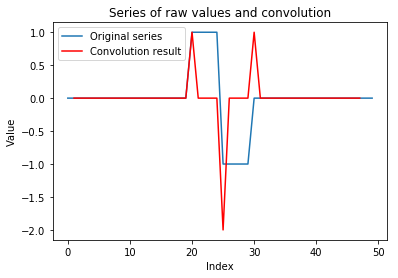

In [65]:
def relu(series):
    return np.array([x if x > 0.0 else 0.0 for x in series])

def plot_detect(series, detect):
    x = list(range(series.shape[0]))
    plt.plot(x, series, label = 'Original series')
    plt.plot(x, detect, color = 'red', label = 'Detected values')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Series of raw values and detected values')

nr.seed(12233)
series = np.concatenate((np.zeros((20,)), np.zeros((5,)) + 1.0, np.zeros((5,)) - 1.0, np.zeros((20,))))
kernel = np.array([-1.0, 1.0, 0.0])
result = conv_1d(series, kernel)
plot_conv(series, result, 3)  

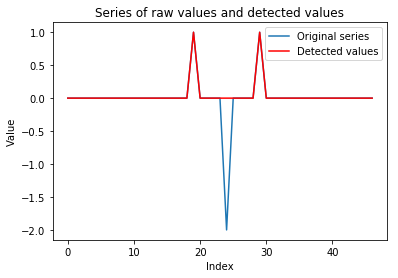

In [66]:
detect = relu(result)
plot_detect(result, detect)

### 1.X Pooling and invariance

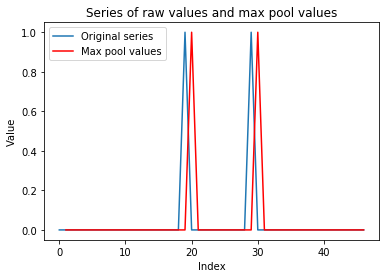

In [58]:
def max_pool_2(series):
    '''Performs simple 1d max pooling with
    an operator span of 2'''
    out =[]
    len = series.shape[0]
    for i in range(0, len - 1):   
        out.append(np.max(series[i:i+1]))
    return np.array(out)    

def plot_pool(series, pool):
    x = list(range(series.shape[0]))
    end = series.shape[0]
    plt.plot(x, series, label = 'Original series')
    plt.plot(x[1:end], pool, color = 'red', label = 'Max pool values')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Series of raw values and max pool values')
     
        
pool = max_pool_2(detect)
plot_pool(detect, pool)   

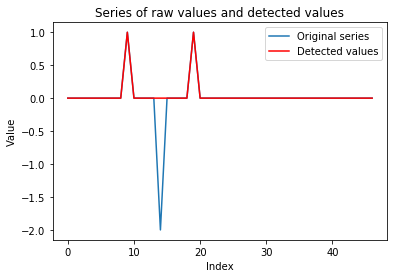

In [60]:
nr.seed(12233)
series = np.concatenate((np.zeros((10,)), np.zeros((5,)) + 1.0, np.zeros((5,)) - 1.0, np.zeros((30,))))
result = conv_1d(series, kernel)
detect = relu(result)
plot_detect(result, detect) 

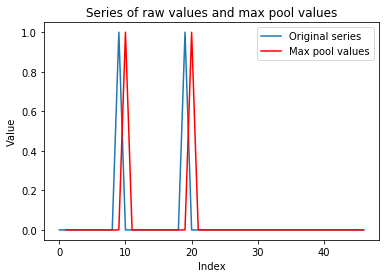

In [61]:
pool = max_pool_2(detect)
plot_pool(detect, pool) 

### 1.X Stride and tiling

## Preparing the dataset

In [6]:
import keras
from keras.datasets import mnist
import keras.utils.np_utils as ku
import keras.models as models
import keras.layers as layers
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

C:\Users\StevePC2\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [8]:
print(train_images.shape, train_labels.shape)

## For convolutional neural network need to retain the shape of each image
## in the tensor so use (60000, 28, 28, 1)
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32')/255
print(train_images.shape)
print(train_images.dtype)

(60000, 28, 28) (60000,)
(60000, 28, 28, 1)
float32


In [9]:
print(test_images.shape, test_labels.shape)
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32')/255
print(test_images.shape)

(10000, 28, 28) (10000,)
(10000, 28, 28, 1)


In [10]:
train_labels = ku.to_categorical(train_labels)
print(train_labels[5:,])

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [11]:
test_labels = ku.to_categorical(test_labels)

## Covolutional neural nets with Keras


You can find [documentation on the convolutional layers in the Keras documentation](https://keras.io/layers/convolutional/).


You can find [documentaton on pooling layers in the Keras documentation](https://keras.io/layers/pooling/).



In [12]:
## Set up and call-backs for early stopping
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 1 # Stop after one step with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True # Only save model if it is the best
        )
]


In [13]:
## Define the Squential model as usual. 
nn = models.Sequential()

## Add some convolutional layers to extract features 
## from the images.
nn.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
nn.add(layers.MaxPooling2D(2, 2))
nn.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
nn.add(layers.MaxPooling2D(2, 2))
nn.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

## Now flatten the output of the convolutional layers so 
## a fully connected network can be applied.
nn.add(layers.Flatten())

## Finally, fully connected layers to classify the digits 
## Using the features extracted by the convolutional layers.
nn.add(layers.Dense(64, activation = 'relu',
                        kernel_regularizer=regularizers.l2(0.01)))
nn.add(Dropout(0.5))
nn.add(layers.Dense(10, activation = 'softmax'))

nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [14]:
## Compile the model
nn.compile(optimizer = 'RMSprop', loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
    
## Now fit the model
history = nn.fit(train_images, train_labels, 
                  epochs = 40, batch_size = 256,
                  validation_data = (test_images, test_labels),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 65s 1ms/step - loss: 0.9030 - acc: 0.8426 - val_loss: 0.2653 - val_acc: 0.9725
Epoch 2/40
60000/60000 [==============================] - 53s 879us/step - loss: 0.2508 - acc: 0.9581 - val_loss: 0.1681 - val_acc: 0.9686
Epoch 3/40
60000/60000 [==============================] - 44s 731us/step - loss: 0.1557 - acc: 0.9712 - val_loss: 0.1218 - val_acc: 0.9744
Epoch 4/40
60000/60000 [==============================] - 49s 816us/step - loss: 0.1245 - acc: 0.9771 - val_loss: 0.0755 - val_acc: 0.9871
Epoch 5/40
60000/60000 [==============================] - 49s 818us/step - loss: 0.1052 - acc: 0.9806 - val_loss: 0.0649 - val_acc: 0.9904
Epoch 6/40
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0949 - acc: 0.9822 - val_loss: 0.0663 - val_acc: 0.98982s - loss: 0.0952 - a


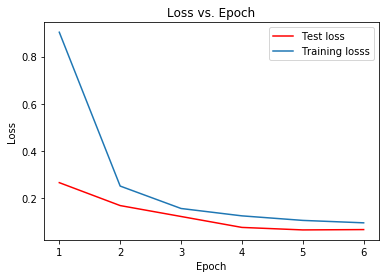

In [30]:
def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'Test loss')
    plt.plot(x, train_loss, label = 'Training losss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    
plot_loss(history)    

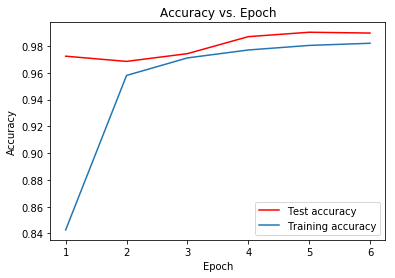

In [31]:
def plot_accuracy(history):
    train_acc = history.history['acc']
    test_acc = history.history['val_acc']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test accuracy')
    plt.plot(x, train_acc, label = 'Training accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')  
    
plot_accuracy(history)   

## What features does the convolutional neural network learn?

(28, 28, 1)


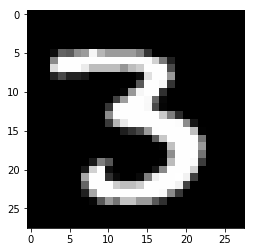

In [17]:
img = train_images[12,:,:,:]
print(img.shape)
plt.imshow(img.reshape((28,28)), cmap = 'gray')

In [18]:
layer_outputs = [layer.output for layer in nn.layers[:7]]
activation_model = models.Model(inputs = nn.input, outputs = layer_outputs)
activations = activation_model.predict(img.reshape(1,28,28,1))

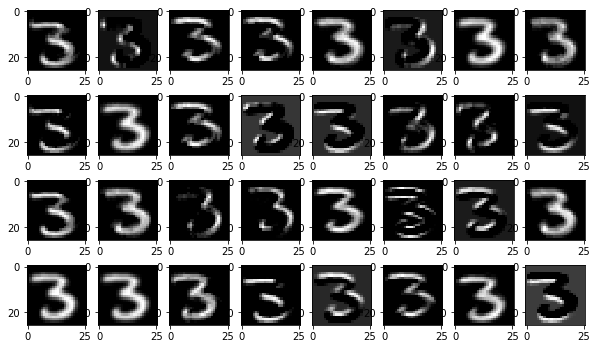

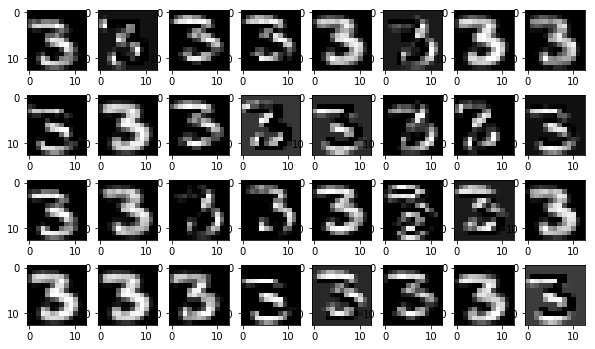

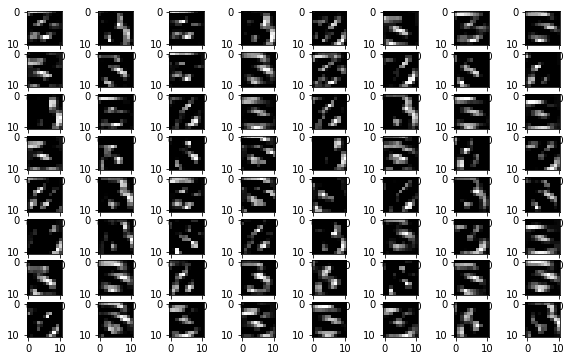

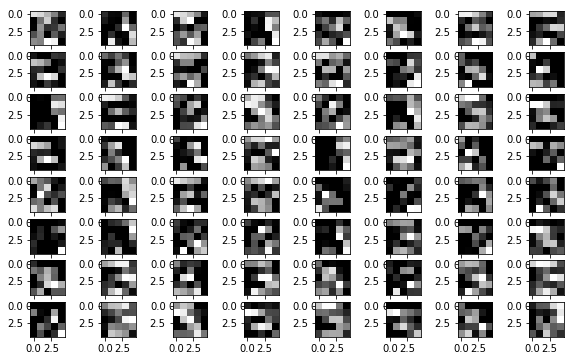

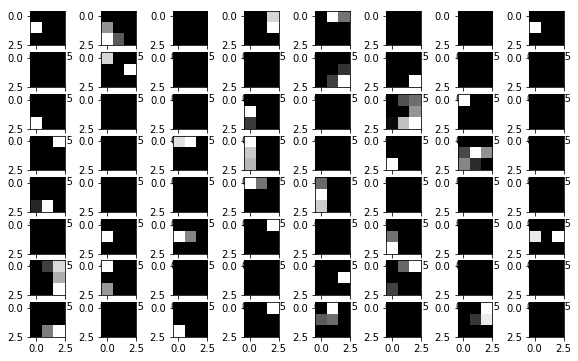

In [19]:
for j in range(5):
    fig_shape = activations[j].shape
    s = fig_shape[3]/32
    fig = plt.figure(figsize=(10,6))
    for i in range(fig_shape[3]):
        a=fig.add_subplot(s*4,8,(i+1))
        plt.imshow(activations[j].reshape((fig_shape[1],fig_shape[2],fig_shape[3]))[:,:,i], cmap='gray')

### What do the filters look like?

## Adding padding

In [20]:
## Define the Squential model as usual. 
nns = models.Sequential()

## Add some convolutional layers to extract features 
## from the images with padding added to the convolution layers.
nns.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
nns.add(layers.MaxPooling2D((2, 2), padding = 'same'))
nns.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
nns.add(layers.MaxPooling2D((2, 2), padding = 'same'))
nns.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))

## Now flatten the output of the convolutional layers so 
## a fully connected network can be applied.
nns.add(layers.Flatten())

## Finally, fully connected layers to classify the digits 
## Using the features extracted by the convolutional layers.
nns.add(layers.Dense(64, activation = 'relu',
                        kernel_regularizer=regularizers.l2(0.01)))
nns.add(Dropout(0.5))
nns.add(layers.Dense(10, activation = 'softmax'))

nns.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                200768    
__________

In [21]:
## Compile the model
nns.compile(optimizer = 'RMSprop', loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
    
## Now fit the model
history_s = nns.fit(train_images, train_labels, 
                  epochs = 40, batch_size = 256,
                  validation_data = (test_images, test_labels),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 88s 1ms/step - loss: 0.6715 - acc: 0.8650 - val_loss: 0.1805 - val_acc: 0.9748
Epoch 2/40
60000/60000 [==============================] - 70s 1ms/step - loss: 0.2253 - acc: 0.9585 - val_loss: 0.1281 - val_acc: 0.9805
Epoch 3/40
60000/60000 [==============================] - 78s 1ms/step - loss: 0.1679 - acc: 0.9700 - val_loss: 0.1163 - val_acc: 0.9793
Epoch 4/40
60000/60000 [==============================] - 94s 2ms/step - loss: 0.1426 - acc: 0.9745 - val_loss: 0.0935 - val_acc: 0.9859
Epoch 5/40
60000/60000 [==============================] - 91s 2ms/step - loss: 0.1233 - acc: 0.9786 - val_loss: 0.0865 - val_acc: 0.9867
Epoch 6/40
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1140 - acc: 0.9807 - val_loss: 0.0825 - val_acc: 0.9873
Epoch 7/40
60000/60000 [==============================] - 79s 1ms/step - loss: 0.1056 - acc: 0.9824 - val_loss: 0.1842 - val_acc

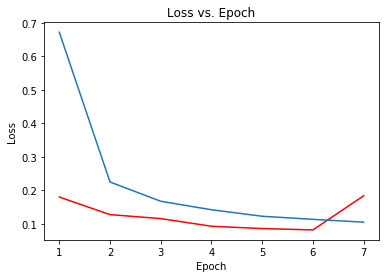

In [22]:
plot_loss(history_s)    

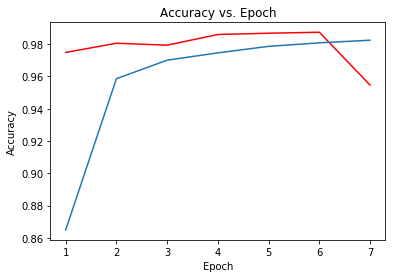

In [23]:
plot_accuracy(history_s) 

#### Copyright 2018, Stephen F Elston. All rights reserved.